# ECG-Pytorch-Classification
@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        

X=np.array(X)
y=np.array(y)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float()
        self.y_train = torch.from_numpy(y_train).long()
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float()
        self.y_test = torch.from_numpy(y_test).long()
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [4]:
num_epochs = 100
log_interval = 10
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_records = 48
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,128,50,stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=3),
   
            nn.Conv1d(128,32,7,stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2,stride=2),
            
            nn.Conv1d(32,32,10,stride=1),
            nn.ReLU(),
            
            nn.Conv1d(32,128,5,stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            
            nn.Conv1d(128,256,15,stride=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(256,512,5,stride=1),
            nn.Conv1d(512,128,3,stride=1),
             
            Flatten(),
            nn.Linear(in_features=1152, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=512, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))

model = arrhythmia_classifier()

In [5]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 128, kernel_size=(50,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(128, 32, kernel_size=(7,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 32, kernel_size=(10,), stride=(1,))
    (9): ReLU()
    (10): Conv1d(32, 128, kernel_size=(5,), stride=(2,))
    (11): ReLU()
    (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv1d(128, 256, kernel_size=(15,), stride=(1,))
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv1d(256, 512, kernel_size=(5,), stride=(1,))
    (17): Conv1

## Construct Loss and Optimizer

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [7]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %d %%' % (100 * correct / total))
    
    
for epoch in range(50):
    train(epoch)
    test()

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 0.08844064
[1,    20] loss: 0.07704939
[1,    30] loss: 0.07579029
[1,    40] loss: 0.07661130
[1,    50] loss: 0.07579376
Accuracy on test set: 28 %
[2,    10] loss: 0.07104434
[2,    20] loss: 0.06887307
[2,    30] loss: 0.06255053
[2,    40] loss: 0.06342170
[2,    50] loss: 0.06224151
Accuracy on test set: 40 %
[3,    10] loss: 0.05938313
[3,    20] loss: 0.06394562
[3,    30] loss: 0.05956198
[3,    40] loss: 0.05122160
[3,    50] loss: 0.05593667
Accuracy on test set: 42 %
[4,    10] loss: 0.05659938
[4,    20] loss: 0.05082442
[4,    30] loss: 0.05268979
[4,    40] loss: 0.05632959
[4,    50] loss: 0.05973385
Accuracy on test set: 38 %
[5,    10] loss: 0.04967780
[5,    20] loss: 0.04412757
[5,    30] loss: 0.04880114
[5,    40] loss: 0.04050486
[5,    50] loss: 0.04367353
Accuracy on test set: 59 %
[6,    10] loss: 0.03478181
[6,    20] loss: 0.04014717
[6,    30] loss: 0.03355349
[6,    40] loss: 0.04251471
[6,    50] loss: 0.04236189
Accuracy on test set: 64 

[49,    10] loss: 0.00000641
[49,    20] loss: 0.00001544
[49,    30] loss: 0.00000207
[49,    40] loss: 0.00000195
[49,    50] loss: 0.00000360
Accuracy on test set: 87 %
[50,    10] loss: 0.00000349
[50,    20] loss: 0.00000268
[50,    30] loss: 0.00001755
[50,    40] loss: 0.00474836
[50,    50] loss: 0.00631624
Accuracy on test set: 77 %


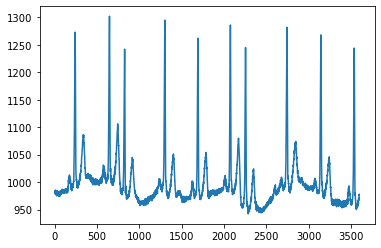

In [8]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [9]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([16,  6,  3,  6, 13,  5, 14,  0,  0,  0, 14,  0,  1,  6,  2, 14])
tensor([16,  0,  3, 12, 13,  5, 14,  0,  0,  0, 14,  0,  1,  6,  2, 14])
tensor([ 0,  5,  0, 12,  6, 13, 11, 16,  0,  0,  6,  0,  4, 13,  6, 16])
tensor([ 0,  5,  0, 12,  6, 13, 11, 16,  0,  6, 12,  0,  4, 13,  6, 16])
tensor([ 0,  7,  9,  1,  0,  5,  4,  3,  6, 14,  0,  3,  3,  6,  7, 14])
tensor([ 6,  7, 10,  1,  0,  5,  3,  3,  6, 14,  0,  3,  3,  3,  7, 14])
tensor([ 7,  1,  7,  2,  0, 13,  3,  0,  9,  0,  6,  0,  0, 16,  5, 11])
tensor([ 7,  1,  7,  2,  0, 13,  3,  0,  9,  0,  7,  0,  6, 16,  5, 11])
tensor([13, 14,  3,  0,  0,  3,  6,  2,  1, 14,  0,  7, 13,  6, 13,  1])
tensor([13, 14,  3,  6,  0,  3,  8,  2,  0, 14,  0,  7, 13,  6, 13,  1])
tensor([ 6,  0, 14,  9,  6,  6,  3,  0,  6,  0,  6, 14, 13, 10,  8,  3])
tensor([ 6,  0, 14,  9,  0,  6,  3,  0,  6,  0,  0, 14, 13, 10,  8,  3])
tensor([ 6,  5,  1,  5, 14,  0,  0, 10,  6,  0,  6,  0, 16,  7,  0,  0])
tensor([ 6,  5,  0,  5, 14,  0,  0, 10,  8,  0,  3,

In [10]:
y_test

array([ 0,  0,  3,  0,  6,  0,  3,  0, 13,  1,  7, 11, 14,  3,  0,  6,  1,
        6,  0,  6,  3, 13,  3,  3,  0,  7, 13,  1,  5,  7,  0,  0,  1, 14,
        3,  0,  0,  3,  7,  3, 13, 14,  6,  6,  2, 14,  0,  1,  5,  6, 13,
       10, 14,  6,  6, 12,  0,  3,  5, 14,  0,  3,  0, 13,  0, 14,  7,  1,
       13, 13,  4, 14,  0,  0,  0,  5,  8,  7,  7,  5,  0,  0,  4,  0, 12,
        0, 13,  0, 13, 16, 14,  2,  0, 13,  8, 16,  6,  6, 13,  0,  6,  0,
        0,  3,  0,  3,  0,  0,  3, 13,  0,  5,  0,  7,  3, 14,  3, 14, 14,
        0, 14,  0, 10,  8,  0,  3,  3,  6,  8,  6, 10,  0,  3,  3, 11,  0,
       14,  0, 16,  7,  1, 13,  0,  0,  6,  6, 14,  0,  0,  0, 16, 14, 10,
        0,  7, 14,  6,  0,  3, 16,  0,  6, 16, 14,  9,  6, 12,  2,  0,  0,
        7, 14,  2,  0, 14, 13,  4, 13,  0,  3,  9,  6,  0,  7,  0,  1,  3,
        6, 16,  0, 14,  7,  3,  6,  0,  0,  1,  1,  0,  3])

Text(0, 0.5, 'Accuracy(%)')

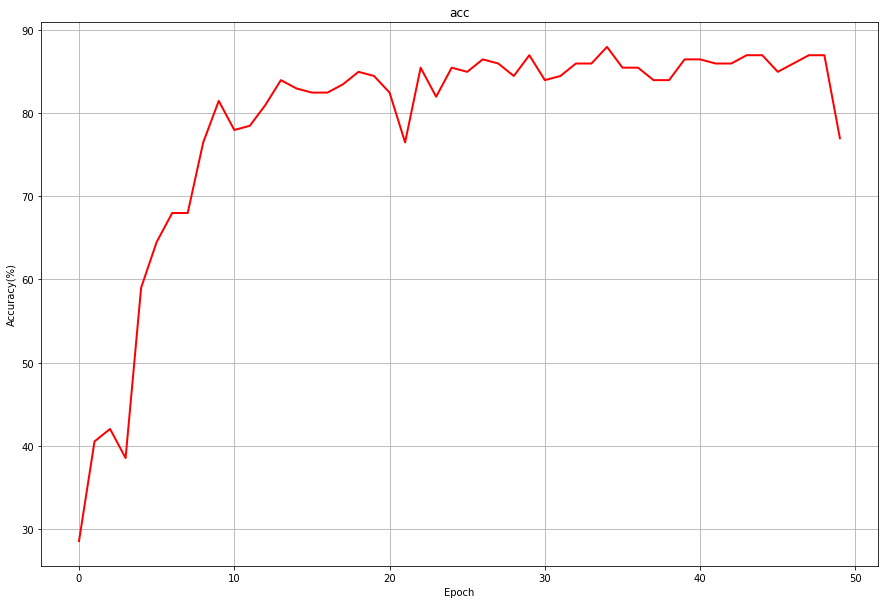

In [11]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')